# Turbulucid tutorial

## Opening the dataset

In this tutorial you will learn how to use turbulucid to analyse and plot data.
We will use a dataset from a computational fluid dynamics simulation of a flow over a backward-facing step (BFS) as an example to learn about the different functionalities of the package!

Lets start by doing some imports and making figures a bit larger than the default size.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from turbulucid import *

matplotlib.rcParams['figure.figsize'] = (12, 6)

The most important class defined by turbulucid is `Case`. A `Case` object contains the dataset that is being analysed and several conenience function for data extraction. Opening a dataset therefore amounts to constructing a `Case` object, which requires a path to the file with the data.
The file can be either VTK polyData in the legacy format (.vtk), VTK polyData in XML format (.vtu) or a multiblock VTK dataset (.vtm) where one block corresponds to the internal data and the other blocks are boundaries. 
Let us open the BFS dataset stored as a .vtm.

In [3]:
case = Case("D:\\bfs\\average.vtm")

The dataset is now opened. Let us inspect some of its properties. The `fields` attribute returns a list of names of the CellData arrays that exist in the dataset. 

In [4]:
print(case.fields)

['U', 'UMean', 'UPrime2Mean', 'U_0', 'p', 'pMean', 'pPrime2Mean']


We can access each field by using the `Case` object as a dictionary, i.e `Case['U']` will return the values of `U` as a `numpy` array.

In [5]:
case['U']

array([[ -1.39072044e-02,   2.96264887e-03,  -5.45554445e-04],
       [ -2.36535128e-02,   9.36659519e-03,  -2.48970184e-03],
       [ -2.15226542e-02,   1.41156698e-02,  -4.84314607e-03],
       ..., 
       [  7.67985153e+00,  -1.48064680e-02,  -1.10125664e-09],
       [  7.67840385e+00,  -9.19818785e-03,  -1.47119861e-09],
       [  7.67761087e+00,  -3.14054522e-03,  -1.28832955e-09]], dtype=float32)

The order of the data corresponds to the order of the cells in the dataset. This doesn't necessarily follow any logical pattern.
However, it is possible to get the location of each cell centre via `Case.cellCentres`.

In [6]:
case.cellCentres

array([[ 0.0002215 , -0.00951875],
       [ 0.0002215 , -0.00934245],
       [ 0.0002215 , -0.00913619],
       ..., 
       [-0.0002215 ,  0.04282301],
       [-0.0002215 ,  0.04479957],
       [-0.0002215 ,  0.04691013]], dtype=float32)

The order in the `cellCentres` array is the same as that of the data for each field. This means that it is possible, for intance, to find the value of field at a certian location by first finding the closest cell centre and the grabbing the field's value at the same index.

It is possible to add additional fields to the case. Let us create a new field -- the magnitude of the mean velocity `UMean`.

In [7]:
case["magUMean"] = np.linalg.norm(case["UMean"], axis=1)
case["magUMean"]

array([  3.42494971e-03,   5.89056220e-03,   5.24617545e-03, ...,
         7.67656279e+00,   7.67511988e+00,   7.67432165e+00])

## Plotting a field

It is time to make a plot! Let us plot the newly created field. This can be done by using the `plot_field` function. The first argument to the function is a `Case` object and the second is the field we want to plot.

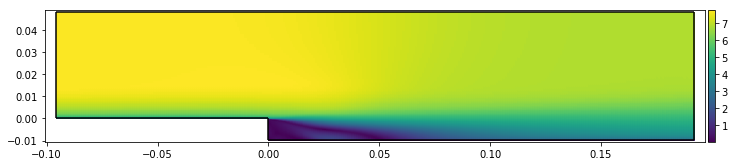

In [8]:
plot_field(case, "magUMean")

Voila! Note that the returned object of `plot_field` is a `PatchCollection`. This means that by assigning `plot_field` to a variable you can further customize the figure. Also, you can pass additional keywork arguments to `plot_field` that will be used in the `PatchCollection` constructor. This allows for a lot of customization. Let us, for instance, use a different colormap.

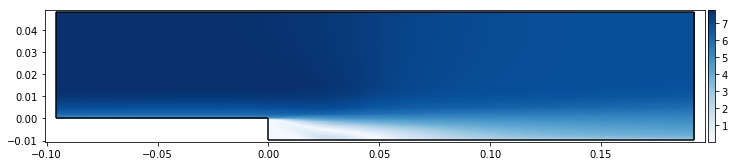

In [9]:
plot_field(case, 'magUMean', cmap='Blues')

Sometimes it is nice to scale the axes by a certain parameter. For the BFS it is common to scale the axes with the height of the step h. To this end `plot_field` and all the other plot functions in turbulucid accept the keyword arguments `scaleX` and `scaleY`.

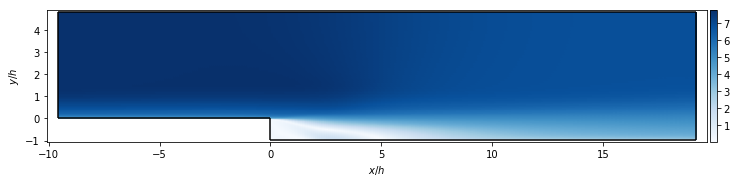

In [10]:
h = 0.01
plot_field(case, 'magUMean', scaleX=h, scaleY=h, cmap='Blues')
plt.xlabel(r'$x/h$')
plt.ylabel(r'$y/h$')

Don't forget that all function is turbulucid have extensive doctrings! Use them to get more information.

In [11]:
?plot_field()

## Plotting vectors

Let us now make a vector plot. This can be done using the `plot_vectors()` function. We need to pass the `Case` object and either the name of a vector field present in the case or an array with several column-components. This alternative is implemented for all the plot functions, including `plot_field` that we looked at above.

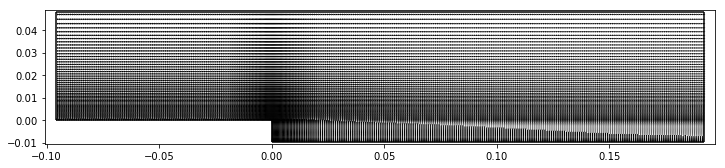

In [12]:
a = plot_vectors(case, 'UMean')

This is not very satisfying. Creating a good vector plot usually needs some tweeking of additional keyword arguments. By default the length of the arrows is proportional to the magnitude of the vector, but this can be changed by the `normalize` keyword.

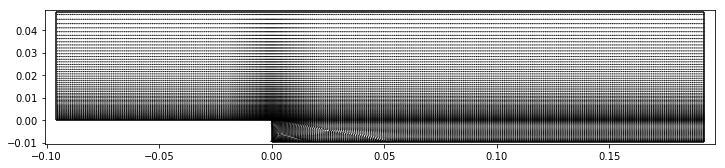

In [13]:
plot_vectors(case, 'UMean', normalize=True)

This perhaps looks slightly better, but the arrows are obviously too small. This can be controlled by the `scale` keyword argument. The behaviour of `scale` is not intuitive -- the larger the value of `scale` the smaller the vectors. This is how the parameter behaves in `pyplot.quiver`, which is the function that `plot_vectors` uses to create the plot, so it was decided to leave that as it is. Typically several iterations are needed to get a good value for `scale`.

Let us make the arrows larger and zoom in on the recirculation zone. Additionally, let us scale the axes.

(-1, 1)

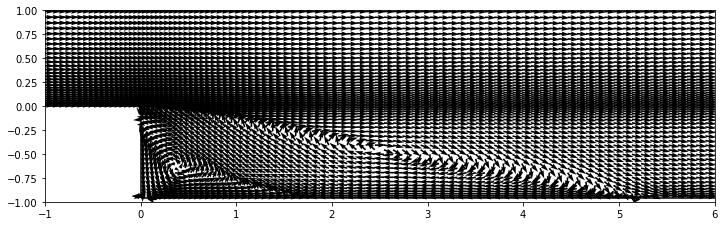

In [14]:
plot_vectors(case, 'UMean', normalize=True, scaleX=h, scaleY=h, scale=60)
plt.xlim([-1, 6])
plt.ylim([-1, 1])

OK, this is looking better, we can clearly see two recirculation boubles. The issue is, however, that there are too much arrows. By default, an arrow will be drawn at each cell center, which means the density of arrows is proportional to the density of the mesh. To avoid this, `plot_vectors` supports another mechanism for positioning the arrows. Instead of using each cell center it is possible to use a Cartesian grid of prescribed resolution to sample the values of the vector field and then plt arrows only at the locations of the nodes of the grid. To do this the `sampleByPlane` keyword argument should be set to `True` and the keyword argument `planeResolution` should provide the amount of nodes in the Cartesian grid in x and y, respectively.

To illustrate the concept let us use a grid with 10 rows and 20 columns.

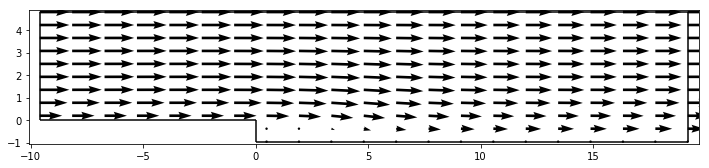

In [15]:
plot_vectors(case, 'UMean', scaleX=h, scaleY=h, sampleByPlane=True, planeResolution=[10,20])

OK, let's now increase the resolution of the mesh, tweak `scale`, and zoom in on the recirculation zone.

(-1, 1)

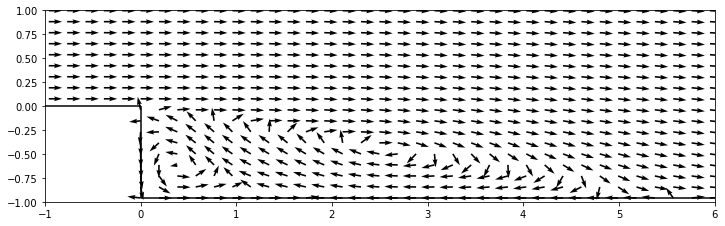

In [16]:
plot_vectors(case, 'UMean', scaleX=h, scaleY=h, normalize=True, sampleByPlane=True, planeResolution=[50,150], scale=50)
plt.xlim([-1, 6])
plt.ylim([-1, 1])

Looking good! Let us finally add some color to the arrows. It is possible to color the arrows by the value of field present in a case. You can also pass an array of values directly, but it is somewhat tricky, when sampling by plane is also used, since the array size and form has to comply to that of the sampling plane.

(-1, 1)

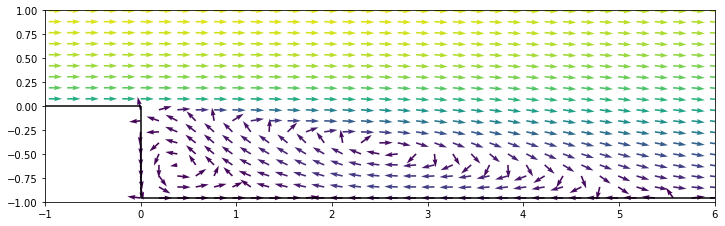

In [17]:
plot_vectors(case, 'UMean', color='magUMean', scaleX=h, scaleY=h, normalize=True, sampleByPlane=True, planeResolution=[50,150], scale=50)
plt.xlim([-1, 6])
plt.ylim([-1, 1])

## Plotting streamlines

Let us now plot some streamlines. The corresponding function is called `plot_streamlines`. As with the other plotting functions, we need to pass a `Case` object and either a field name or an array.

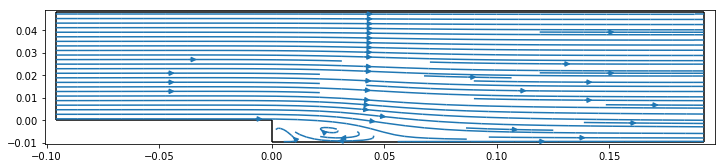

In [18]:
plot_streamlines(case, 'UMean')

This looks quite nice already. Under the hood the function uses `pyplot.streamplot`. Unfortunately, `pyplot.streamplot` does not work with unstructured datasets, and requires data stored on a Cartesian grid. For this reason, `plot_streamlines` always uses the approach used by `plot_vectors` when the `sampleByPlane` keyword argrument is set to True. The plane resolution is set by default to be 50 rows and 50 columns. This, of course, can be adjusted.

As with the vectors, we can add color.

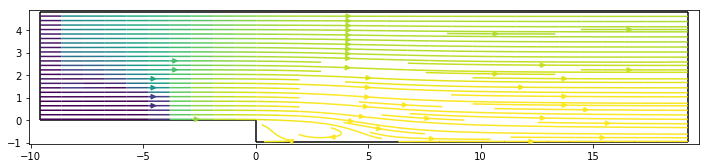

In [19]:
plot_streamlines(case, 'UMean', color='magUMean', planeResolution=[300,300], scaleX=h, scaleY=h)

Quite a lot of cutomisation is possible by passing additional keyword arguments, for instance the locations of the seed points for the streamlines. Overall, however, `pyplot.streamplot` is not the ideal function to rely on and in the future it will probably be attempted to use VTK to compute the streamlines. 

## Auxillary plotting functions

Two additionaly plotting functions are probided by the library. The first one, `plot_boundary` simply plots the boundary of the domain.

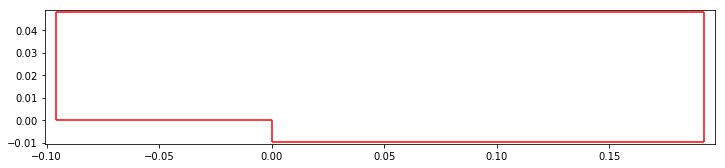

In [20]:
plot_boundaries(case, color="Red")

The second, `add_colorbar`, adds a colorbar to the plot. This can be useful if more control over the colorbar is needed. By default `plot_field` adds a colorbar on its own, but this can be avoided by setting the `colorbar` keyword argument to False.

## Extracting a profile along a line

As it was mentioned in the beginning, the most general way of extracting values from  specific locations is working with the `cellCentres` attribute of the `Case` class.
However, turbulucid defines several functions that cover commonly needed data extraction procedures.
One of the is `profile_along_line` which alows to extract a linear profile between two points in the dataset.

In [21]:
point1 = (-0.05, -1)
point2 = (-0.05, 1)
points, data = profile_along_line(case, point1, point2)

Let us explore what has been returned by the function. Firstly, note that we have two returned objects. The first one, assigned to `points` is a 1D array which holds the locations, along the line, where the sampled data is located.

In [22]:
points

array([ 1.        ,  1.00007855,  1.00024034,  1.00041176,  1.00059338,
        1.00078581,  1.00098969,  1.00120571,  1.00143459,  1.0016771 ,
        1.00193404,  1.00220627,  1.00249471,  1.00280032,  1.00312413,
        1.0034672 ,  1.0038307 ,  1.00421584,  1.0046239 ,  1.00505625,
        1.00551434,  1.00600127,  1.00651125,  1.00703631,  1.00757691,
        1.00813349,  1.00870654,  1.00929655,  1.009904  ,  1.01052942,
        1.01117335,  1.0118723 ,  1.0126278 ,  1.01340544,  1.01420587,
        1.01502975,  1.01587777,  1.01675064,  1.01764909,  1.01857387,
        1.01952574,  1.02050551,  1.02151398,  1.02255201,  1.02362045,
        1.0247202 ,  1.02585218,  1.02701732,  1.02821661,  1.02945103,
        1.03072163,  1.03202946,  1.03337562,  1.03476122,  1.03618742,
        1.03765541,  1.03923836,  1.04097193,  1.04282301,  1.04479957,
        1.04691013,  1.048     ])

Note that the first value is 1. This reflects the fact that the line was defined as a vertical segment between y=-1 and y=1, and the first datapoint we have is located at y=0, which then corresponds to a distance of 1 in y from `point1`.
Quite often it is convenient to subtract the length of the segment, where no data resides, so that the first coordinate is always 0. This can be done with the `correctDistance` keyword.

In [23]:
points, data = profile_along_line(case, point1, point2, correctDistance=True)
points

array([  0.00000000e+00,   7.85546436e-05,   2.40339985e-04,
         4.11755755e-04,   5.93375240e-04,   7.85805867e-04,
         9.89691005e-04,   1.20571279e-03,   1.43459346e-03,
         1.67709845e-03,   1.93403871e-03,   2.20627384e-03,
         2.49471376e-03,   2.80032353e-03,   3.12412530e-03,
         3.46720126e-03,   3.83069925e-03,   4.21583513e-03,
         4.62389644e-03,   5.05624805e-03,   5.51433582e-03,
         6.00127224e-03,   6.51125005e-03,   7.03631341e-03,
         7.57690798e-03,   8.13349430e-03,   8.70654453e-03,
         9.29654576e-03,   9.90399905e-03,   1.05294222e-02,
         1.11733451e-02,   1.18722972e-02,   1.26277991e-02,
         1.34054404e-02,   1.42058674e-02,   1.50297489e-02,
         1.58777721e-02,   1.67506449e-02,   1.76490936e-02,
         1.85738690e-02,   1.95257440e-02,   2.05055103e-02,
         2.15139836e-02,   2.25520097e-02,   2.36204527e-02,
         2.47202031e-02,   2.58521773e-02,   2.70173214e-02,
         2.82166079e-02,

Let us now consider the second returned object. It is a dictionary with the same keys as the `Case` object, i.e the names of the fields present in the case. Similarly, the values for each key is the values of the corresponding field at locations along the line.

In [24]:
print(data.keys())
data['magUMean']

dict_keys(['U', 'U_0', 'magUMean', 'UMean', 'pPrime2Mean', 'p', 'UPrime2Mean', 'pMean'])


array([ 0.78923261,  0.78923261,  2.29034233,  3.43619037,  4.1814723 ,
        4.67278194,  5.01791286,  5.27699232,  5.4826827 ,  5.6540904 ,
        5.8026371 ,  5.93444586,  6.05443668,  6.16568756,  6.27085638,
        6.37193489,  6.46978283,  6.56556988,  6.65970755,  6.75241089,
        6.84401321,  6.93536472,  7.02430773,  7.10863686,  7.18908167,
        7.26502657,  7.33669472,  7.40459585,  7.46730995,  7.52374792,
        7.57336426,  7.61656809,  7.65741873,  7.69035673,  7.72397327,
        7.74356174,  7.74349022,  7.73991108,  7.7373333 ,  7.73548031,
        7.7341218 ,  7.73295736,  7.73194599,  7.73101282,  7.73014021,
        7.72931767,  7.72853041,  7.72778225,  7.72706652,  7.72638702,
        7.72573185,  7.72511435,  7.72454262,  7.7239995 ,  7.7235074 ,
        7.72304535,  7.72263718,  7.72225523,  7.72194338,  7.72171354,
        7.72159624,  7.43818283])

Now that we have the data we can use Python's plotting routines to make line-plots.

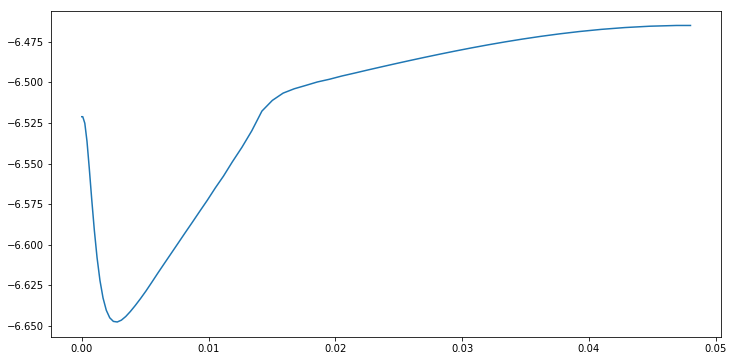

In [25]:
plt.plot(points, data['pMean'])

Combining with ploting function we can do more fancy things

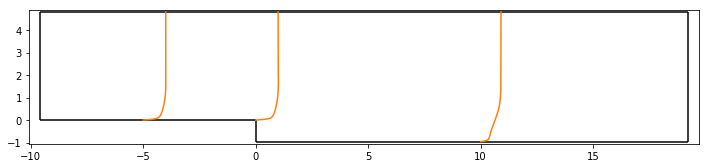

In [26]:
plot_boundaries(case, scaleX=h, scaleY=h)
Uref = data['UMean'][-1 ,0]

point1, point2 = (-0.05, 0), (-0.05, 1)
points, data = profile_along_line(case, point1, point2)
plt.plot(data['UMean'][:,0]/Uref - 0.05/h, points/h, 'C1')

point1, point2 = (0, 0), (0, 1)
points, data = profile_along_line(case, point1, point2)
plt.plot(data['UMean'][:,0]/Uref, points/h, 'C1')

point1, point2 = (0.1, -h), (0.1, 1)
points, data = profile_along_line(case, point1, point2)
plt.plot(data['UMean'][:,0]/Uref + 0.1/h, points/h-1, 'C1')

## Extracting boundary data

As it was briefly mentioned in the beginning, turbulucid supports reading data from a multiblock dataset (.vtm), where one block corresponds to the internal field and the other corresponds to defined named boudaries. Functions are provided for accessing both the data on the boundaries, but also from internal cells which are on the boundary, i.e. have one edge that is part of the boundary.

If a .vtk or .vtu file is read, one boundary, called `boundary`, is defined. Too see what boundaries are present the `boundaries` attribute of the `Case` object can be used.

In [27]:
case.boundaries

['inletB', 'outletB', 'stepB', 'lowB1', 'lowB2', 'upB']

Too access data on the boundary, the `boundary_data` memeber function of the `Case` object can be used. The name of the boundary is passed as argument.

In [28]:
points, data = case.boundary_data('inletB')

The structure of the returned values is similar to `profile_along_line`. The first returned object is an array, defining the location of the edge centres of the boundary edges.

In [31]:
points[:10, :]

array([[ -9.60000008e-02,   7.85546436e-05,   0.00000000e+00],
       [ -9.60000008e-02,   2.40339985e-04,   0.00000000e+00],
       [ -9.60000008e-02,   4.11755755e-04,   0.00000000e+00],
       [ -9.60000008e-02,   5.93375240e-04,   0.00000000e+00],
       [ -9.60000008e-02,   7.85805867e-04,   0.00000000e+00],
       [ -9.60000008e-02,   9.89691005e-04,   0.00000000e+00],
       [ -9.60000008e-02,   1.20571279e-03,   0.00000000e+00],
       [ -9.60000008e-02,   1.43459346e-03,   0.00000000e+00],
       [ -9.60000008e-02,   1.67709845e-03,   0.00000000e+00],
       [ -9.60000008e-02,   1.93403871e-03,   0.00000000e+00]], dtype=float32)

The second returned object is the dictionary with the data.

Similarly the `boundary_cell_data` member function returns the values in the boundary-adjacent cells. The order of the values is the same is that returned by `boundary_data`.

Another function in turbulucid, `dist` can be used to compute the distance between the cell centers of the boundary-adjacent cells and a given boundary.

In [38]:
dist(case, 'stepB')

array([ 0.0002215,  0.0002215,  0.0002215,  0.0002215,  0.0002215,
        0.0002215,  0.0002215,  0.0002215,  0.0002215,  0.0002215,
        0.0002215,  0.0002215,  0.0002215,  0.0002215,  0.0002215,
        0.0002215,  0.0002215,  0.0002215,  0.0002215,  0.0002215,
        0.0002215,  0.0002215,  0.0002215,  0.0002215,  0.0002215,
        0.0002215])

In this case all the distances are the same due to the geometry being meshed with rectangles.

This covers most of the functionality in turbulucid! More things are available, to explore them look at the code reference!